In [1]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8d683273154ae056d43ab32803818edd8f9cf6537a1c1128592507b46b818ee8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


✅ Data shape: (923298, 18)

📘 X_train_scaled (first 5 rows):
        BVP       EDA      TEMP      AccX      AccY      AccZ        HR  \
0 -3.637107 -0.640298 -1.000436  1.394057 -0.646130  1.189580 -0.551251   
1  0.179808 -0.658935  0.727069 -0.420363 -1.194035  0.154585  0.276302   
2 -0.210431  0.885215 -0.520573 -0.280793  0.527954  0.622002 -0.306659   
3  0.002711 -0.671679  1.004322 -0.746029  0.606226  0.187972  0.778055   
4  7.028627  1.978133  1.398876 -1.118217 -0.606993 -1.013957  0.036544   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0 -0.543635  2.613001 -0.521736  0.382069 -0.379010 -0.168772  8.611543   
1 -0.445946 -0.545911  0.495684 -0.675699 -0.678930  0.440231 -0.451797   
2 -0.295491 -0.201855 -0.510869 -0.537818 -0.722953  0.909343  0.180146   
3 -0.499958 -0.311743  0.238484  0.314970  4.912600 -0.537903 -0.353875   
4 -0.704435 -0.489852 -0.651057  0.049133  0.844237 -0.027085  0.134743   

     Gamma2   Attention   Meditation 

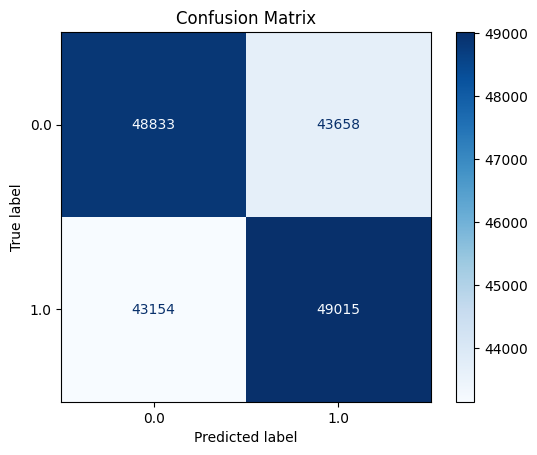

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                    0.027810
1       1              0.0                    0.000705
2       2              1.0                    0.047864
3       3              0.0                    0.000824
4       4              1.0                    0.008218


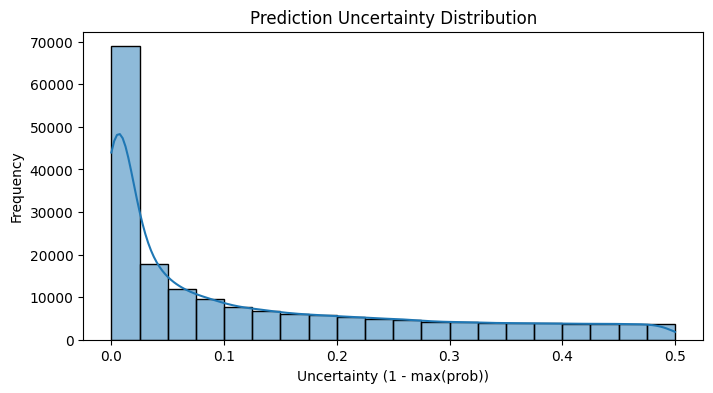

 95%|=================== | 190/200 [00:16<00:00]       

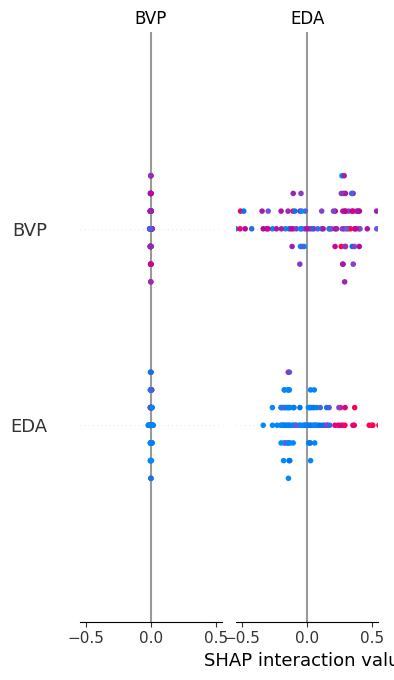


🟡 LIME Explanation for First Sample:
[('TEMP <= -0.46', 0.11028227363277075), ('-0.65 < EDA <= -0.43', -0.08110730357777565), ('AccY > 0.49', -0.07730218018588467), ('0.25 < AccZ <= 0.82', 0.037156560842451274), (' Gamma2 <= -0.63', 0.01756422810887522), (' Attention > 0.87', -0.010337514549363052), ('-0.39 <  Gamma1 <= 0.26', -0.0051746541631876855), (' Beta1 <= -0.65', -0.004921792883386835), ('-0.38 <  Alpha2 <= 0.24', 0.004875977331926106), (' Beta2 <= -0.65', -0.004804495031312165)]

✅ Results saved to 'BrainNetwork_Model_Results.xlsx'


In [2]:
# brain_network_classifier_uncertainty_xai.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings("ignore")

# Hypothetical Brain Network Classifier
class BrainNetworkClassifier:
    def __init__(self, n_nodes=100, learning_rate=0.01, random_state=42):
        self.n_nodes = n_nodes
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.weights = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.classes_ = np.unique(y)
        self.input_dim = X.shape[1]
        self.output_dim = len(self.classes_)
        self.weights = np.random.randn(self.input_dim, self.output_dim)
        for _ in range(self.n_nodes):
            outputs = X @ self.weights
            probs = self._softmax(outputs)
            error = y - probs
            self.weights += self.learning_rate * X.T @ error / X.shape[0]
        return self

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / e_x.sum(axis=1, keepdims=True)

    def predict_proba(self, X):
        if self.weights is None:
            raise ValueError("Model not trained.")
        outputs = X @ self.weights
        return self._softmax(outputs)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)

def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/MID/MEFAR_MID.csv")
    data.dropna(inplace=True)
    print("✅ Data shape:", data.shape)

    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']
    encoder = OneHotEncoder()
    y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    y_train_class = np.argmax(y_train, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = BrainNetworkClassifier()
    clf.fit(X_train_scaled, y_train)

    y_pred_prob = clf.predict_proba(X_test_scaled)
    y_pred_class = clf.predict(X_test_scaled)

    # Convert arrays to DataFrames
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    y_pred_class_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred_class)})
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # Display them
    print("\n📘 X_train_scaled (first 5 rows):")
    print(X_train_df.head())

    print("\n📗 X_test_scaled (first 5 rows):")
    print(X_test_df.head())

    print("\n📙 Predicted Classes (first 5):")
    print(y_pred_class_df.head())

    print("\n📕 Predicted Probabilities (first 5 rows):")
    print(y_pred_prob_df.head())


    acc = accuracy_score(y_test_class, y_pred_class)
    prec = precision_score(y_test_class, y_pred_class, average='weighted')
    rec = recall_score(y_test_class, y_pred_class, average='weighted')
    f1 = f1_score(y_test_class, y_pred_class, average='weighted')
    mcc = matthews_corrcoef(y_test_class, y_pred_class)
    report = classification_report(y_test_class, y_pred_class, target_names=classes)
    cm = confusion_matrix(y_test_class, y_pred_class)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test_class, y_pred_class)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_prob)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred_class),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train_class)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], rf.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("BrainNetwork_Model_Results.xlsx", index=False)
    print("\n✅ Results saved to 'BrainNetwork_Model_Results.xlsx'")

if __name__ == "__main__":
    main()
